Axios [reported](https://www.axios.com/coronavirus-global-economic-risk-stock-market-china-24da74a5-c824-4c79-a8c7-220213d28824.html) a few weeks back on growing concern from economists about the understated risks to the global economy posed by coronavirus. The report cites an interesting statistic about the attention paid to coronavirus on recent earnings calls:

> Of the 364 companies that have held Q4 earnings calls, 138 cited the term "coronavirus" during the call, and about 25% of those included some impact from the coronavirus or modified guidance due to the virus, according to FactSet.

Additionally, the author cites a [note](https://www.guggenheiminvestments.com/perspectives/global-cio-outlook/coronavirus-impact-on-the-global-economy) in which Scott Minerd, global CIO of Guggenheim Investments, compares the "cognitive dissonance" of market participants to the assurances given by Neville Chamberlain to Britain on the eve of World War II.

These fears materialized shortly after as markets crashed and continue to crash. My mind came back to this statistic, so I pulled the transcripts and started analyzing.

## Data Acquisition

The Motley Fool provides earnings call transcripts for the companies that they cover in a [centralized place](https://www.fool.com/earnings-call-transcripts/), making it quite easy to scrape and parse. Global media outlets picked up the story in early January, so I pulled transcripts from all earnings calls occurring in 2020 (as of February 29th). This leaves us with data on 2,277 unique earnings calls.

The transcripts all follow a standardized structure, so I parse the data out according to their logical sections. A sample fully parsed document is shown below. The most relevant fields for this analysis are the prepared remarks section and the Q&A section which hold the relevant transcribed text from the call.

In the analysis that follows, I say that an earnings call "discusses the outbreak" or "mentions the coronavirus" if it contains either the term "coronavirus" or "covid".

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import datapackage
import re
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
plt.style.use("fivethirtyeight")

# read the earnings calls, convert dates, and drop any where the original
# date of the call was before 2020 (or wasn't able to be parsed)
df = pd.read_csv("data/earnings_calls.csv")
df.fillna("", inplace=True)
df["date"] = pd.to_datetime(df.date)
df = df[~df.date.isna() & (df.date >= "2020-01-01")]

# find which ones mention coronavirus
_has_coronavirus = lambda x: re.search(r"(coronavirus)|(covid)", x, re.I) is not None
df["prepared_remarks_cv"] = df.prepared_remarks.apply(_has_coronavirus)
df["questions_and_answers_cv"] = df.questions_and_answers.apply(_has_coronavirus)
df["any_cv"] = df.prepared_remarks_cv | df.questions_and_answers_cv

# strip out quarter
df["quarter"] = df.title.apply(lambda x: re.search(r"Q(1|2|3|4)", x).group(0))

# order by date
df = df.sort_values("date").reset_index(drop=True)

# obtain sector data for S&P 500 companies from https://datahub.io/core/s-and-p-500-companies
sector_data = pd.read_csv("data/s_and_p_sectors.csv")

# join in sector data for S&P 500 companies
df["ticker_split"] = df.ticker.apply(lambda x: x.split(":")[1])
df = pd.merge(df, sector_data, how="left", left_on="ticker_split", right_on="Symbol")

## Rising Concern

Unsurprisingly, discussion of the outbreak and its impact in earnings calls has been steadily rising, starting in the last week of January. A total of 45% of calls in this dataset mention coronavirus.

This number, however, is heavily dependent on the chosen time range. Measured as a cumulative proportion over time, it continues to climb, and the (noisy) proportion on any given day in recent weeks hovers around 50%.

In [13]:
df.any_cv.mean()

0.4460458240946046

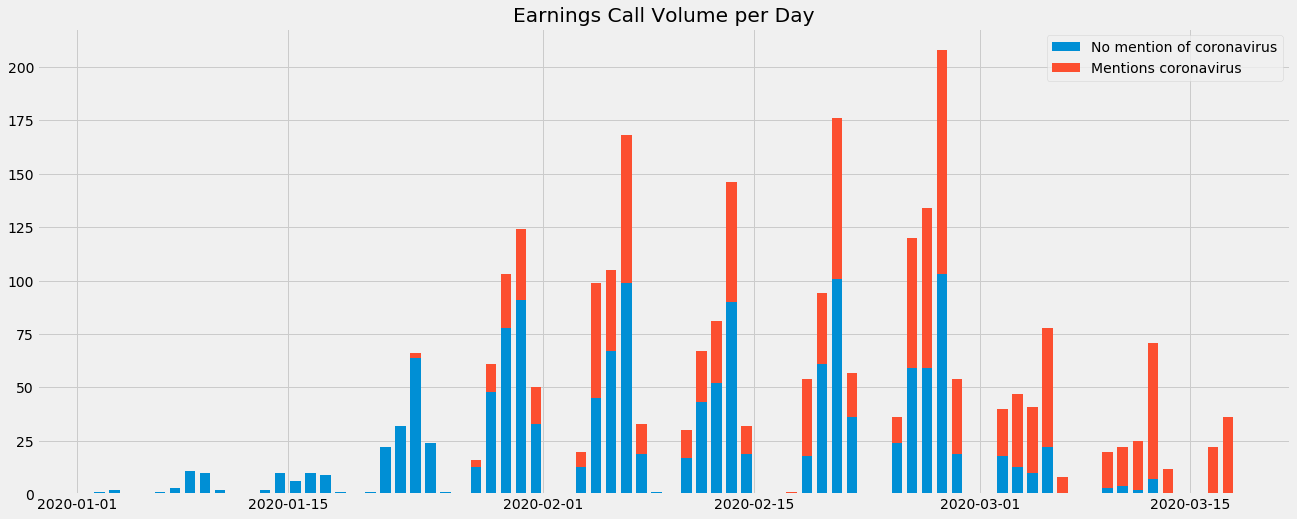

In [14]:
plt.figure(figsize=(20,8))
plt.hist(
    [df.date[~df.any_cv], df.date[df.any_cv]],
    bins=(df.date.max() - df.date.min()).days,
    stacked=True,
    label=["No mention of coronavirus", "Mentions coronavirus"],
    rwidth=.7
)
plt.title("Earnings Call Volume per Day")
plt.legend();

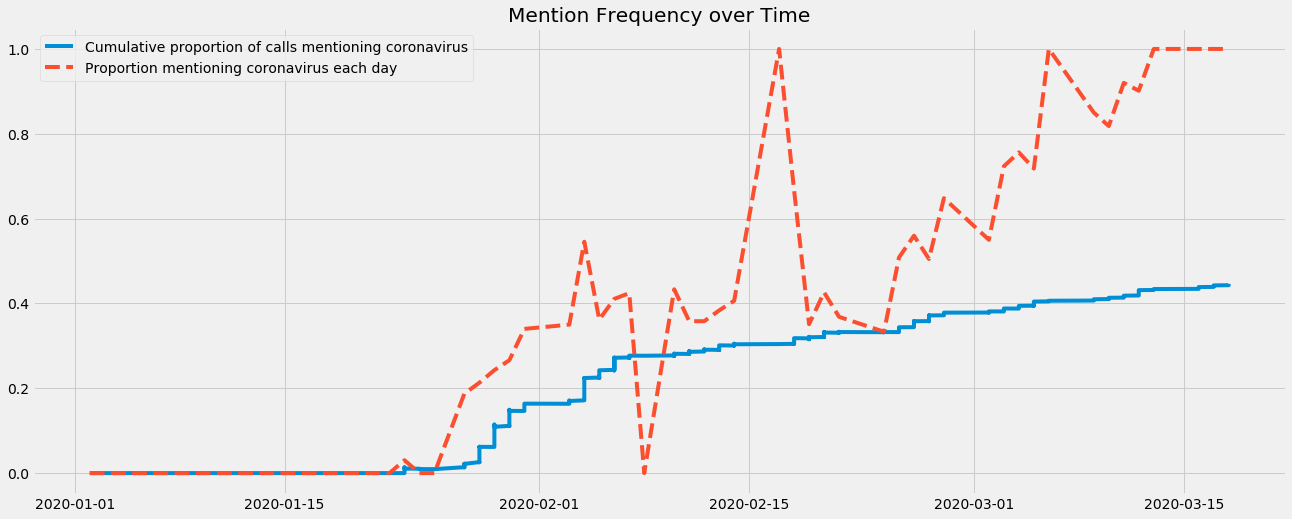

In [15]:
plt.figure(figsize=(20,8))
cumulative_proportion = df.any_cv.cumsum() / (df.index.values + 1)
cum_prop = pd.Series(cumulative_proportion.values, index=df.date, name="cumprop")
by_day = df.groupby("date").mean()["any_cv"]
cc = pd.concat([by_day, cum_prop], axis=1)
plt.plot(cc["cumprop"], label="Cumulative proportion of calls mentioning coronavirus")
plt.plot(cc["any_cv"], linestyle="--", label="Proportion mentioning coronavirus each day")
plt.title("Mention Frequency over Time")
plt.legend();

## Across Sectors

To better understand where most attention, I pulled metadata for S&P 500 companies and joined that with the earnings call dataset. This leaves us with sector level data for the 406 S&P 500 companies in the earnings call dataset.

Service sectors such as Financials and Utilities appear be the most immune.

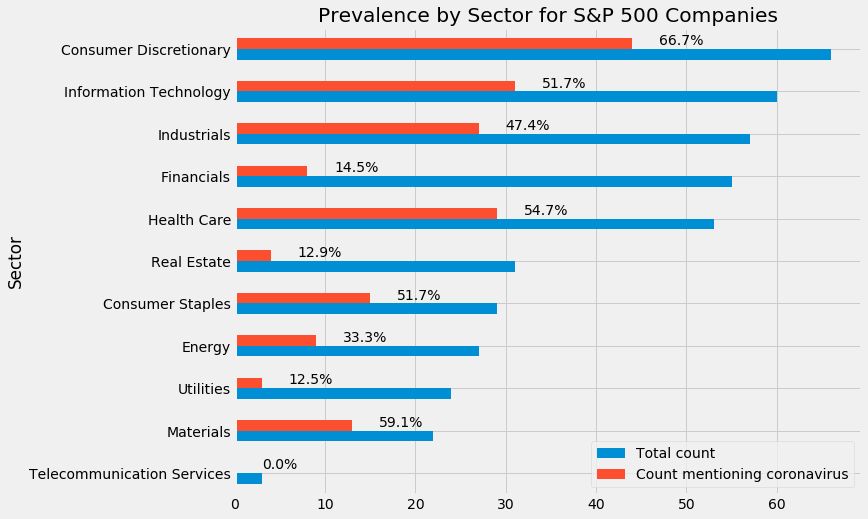

In [16]:
counts_by_sector = df.groupby("Sector").agg(["size", "sum"])["any_cv"].sort_values("size")
ax = counts_by_sector.plot(
    kind="barh",
    figsize=(10, 8),
    title="Prevalence by Sector for S&P 500 Companies"
)
for i, (_, row) in enumerate(counts_by_sector.iterrows()):
    ax.text(row["sum"] + 3, i + .1, "{:.1f}%".format(100 * row["sum"] / row["size"]))
ax.legend(["Total count", "Count mentioning coronavirus"]);

## Analyst Concerns

What concerns do analysts have?

In [ ]:
top_questions = questions[questions.apply(lambda x: x != "")].sample(n=10)
top_questions.name = "cv_questions"

In [ ]:
for _, row in df.join(top_questions, how="inner").iterrows():
    print(row["name"])
    print(row["cv_questions"])
    print()

In [ ]:
questions[questions.apply(lambda x: x != "")].sample

In [ ]:
print(df[questions.apply(lambda x: x != "")].iloc[104].prepared_remarks)

## Language

In [ ]:
questions = df.questions_and_answers

In [ ]:
cv_sentences = df.prepared_remarks[df.prepared_remarks_cv].apply(lambda x: " ".join([s for s in sent_tokenize(x) if _has_coronavirus(s)]))

In [ ]:
questions = df.questions_and_answers.apply(
    lambda x: " ".join([s for s in sent_tokenize(x) if _has_coronavirus(s) and s.endswith("?")]))

In [ ]:
vec = CountVectorizer(stop_words="english")
count_matrix = vec.fit_transform(questions[questions.apply(lambda x: x != "")])
feature_counts = dict(zip(vec.get_feature_names(), np.asarray(count_matrix.sum(axis=0)).flatten()))

In [ ]:
Counter(feature_counts).most_common()

In [ ]:
vec = CountVectorizer(stop_words="english")


In [ ]:
counts = vec.fit_transform(cv_sentences)
counts2 = vec2.fit_transform(cv_qa)

In [ ]:
counts_list = np.asarray(counts.sum(axis=0)).flatten()
counts_list2 = np.asarray(counts2.sum(axis=0)).flatten()

In [ ]:
count_dict = dict(zip(vec.get_feature_names(), counts_list))
count_dict2 = dict(zip(vec2.get_feature_names(), counts_list2))

In [ ]:
Counter(count_dict).most_common()

In [ ]:
Counter(count_dict2).most_common()

In [ ]:
df["only_qa"] = df.questions_and_answers_cv & ~df.prepared_remarks_cv
only_qa_proportion = df.groupby("date").sum()
(only_qa_proportion["only_qa"] / only_qa_proportion["any_cv"]).plot()